# Solution to DPS Challenge June 2022

This ipynb contains my submission to DPS challenge of 2022. 

# Data loading

In [105]:
import os
import pickle
import chardet
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# working_directory = os.getcwd()
# print(working_directory)

In [142]:
# Alternative on Google Drive
from google.colab import drive 
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [100]:
# BASE_PATH = './'
BASE_PATH = '/content/drive/MyDrive/DPS/'
file_name = '220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'
file_path = BASE_PATH + file_name

In [107]:
def get_file_encoding(file_name):
    with open(file=file_name, mode='rb') as inp:
        encoding= chardet.detect(inp.read(10000))['encoding']
    return encoding

In [108]:
df = pd.read_csv(file_path, sep=',', encoding=get_file_encoding(file_path))

In [109]:
df.shape

(2086, 9)

# EDA

In [ ]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN,16.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN,14.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN,24.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN,16.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN,24.0,NaN,NaN,NaN


In [ ]:
df.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

In [ ]:
df.MONATSZAHL.unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [ ]:
df.AUSPRAEGUNG.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [ ]:
df.JAHR.nunique()

23

In [ ]:
df.MONAT.nunique()

277

In [ ]:
df.WERT.isna().sum()

84

In [ ]:
df[df.MONAT == 'Summe'].shape

(154, 9)

# Data Pre-Processing

In [150]:
important_columns = ['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']
df = df[important_columns]

In [111]:
df.isna().sum()

MONATSZAHL      0
AUSPRAEGUNG     0
JAHR            0
MONAT           0
WERT           84
dtype: int64

In [112]:
df.dropna(inplace=True)

In [113]:
df.shape

(2002, 5)

In [114]:
df = df[(df.MONATSZAHL == 'Alkoholunfälle') & (df.AUSPRAEGUNG == 'insgesamt')]

In [115]:
df = df[df.MONAT != 'Summe']

In [116]:
from tqdm import tqdm
tqdm.pandas()

def split_month(monat_entry):
    _, month_field = monat_entry[0:4], monat_entry[4:]
    return pd.Series([month_field])

df[['MONAT']] = df.MONAT.progress_apply(split_month)

100%|██████████| 264/264 [00:00<00:00, 3894.56it/s]


In [117]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
13,Alkoholunfälle,insgesamt,2021,01,16.0
14,Alkoholunfälle,insgesamt,2021,02,14.0
15,Alkoholunfälle,insgesamt,2021,03,24.0
16,Alkoholunfälle,insgesamt,2021,04,16.0
17,Alkoholunfälle,insgesamt,2021,05,24.0


In [118]:
working_df = df[df.JAHR <= 2020]
ground_truth_df = df[df.JAHR > 2020]
working_df.shape, ground_truth_df.shape

((252, 5), (12, 5))

# Visualization

# Statistical Testing

## The reason behind this statistical testing

As the data is based on alcohol related accidents, I have a hypothesis that there could be a seasonal pattern in the data. Because, as alcohol keeps our body warm, people might tend to consume more alcohol during the winter period, which will lead to an increased amount of accidents due to alcohol consumption. In order to test this hypothesis, I resort to Augmented Dickey Fuller test for stationarity in the data. The null hypothesis of this test assumes there is no stationarity in the data. Should we fail to reject this null hypothesis, we can conclude that there **could be** a season pattern in the data.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df[['WERT']],autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    1.670824              Test Statistics
1    0.998055                      p-value
2   11.000000             No. of lags used
3  252.000000  Number of observations used
4   -3.456569          critical value (1%)
5   -2.873079          critical value (5%)
6   -2.572919         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the WERT.

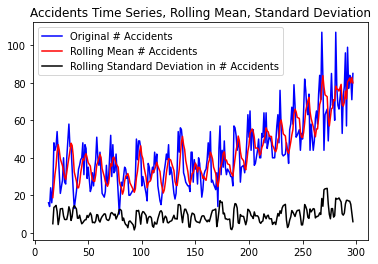

In [ ]:
import matplotlib.pyplot as plt


rolling_mean = df[['WERT']].rolling(5).mean()
rolling_std = df[['WERT']].rolling(5).std()
plt.plot(df[['WERT']], color="blue",label="Original # Accidents")
plt.plot(rolling_mean, color="red", label="Rolling Mean # Accidents")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in # Accidents")
plt.title("Accidents Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

# Statistical Modeling

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 604 kB 3.8 MB/s eta 0:00:01


In [ ]:
working_df.WERT

26     28.0
27     40.0
28     27.0
29     26.0
30     40.0
       ... 
293    77.0
294    84.0
295    83.0
296    71.0
297    85.0
Name: WERT, Length: 252, dtype: float64

In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(working_df.WERT, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(working_df.WERT)
forecast = model.predict(n_periods=len(ground_truth_df.WERT))
forecast = pd.DataFrame(forecast,index = ground_truth_df.WERT.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1990.626, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1952.351, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1944.274, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1988.706, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1915.901, Time=0.07 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-p

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1914.760, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1948.722, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1915.948, Time=0.14 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1949.977, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1917.297, Time=0.06 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.277 seconds


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

rms = sqrt(mean_squared_error(ground_truth_df.WERT, forecast))
mae = mean_absolute_error(ground_truth_df.WERT, forecast)
print("RMSE: ", rms)
print('MAE: ', mae)

RMSE:  47.78267487700012
MAE:  45.68159770739165


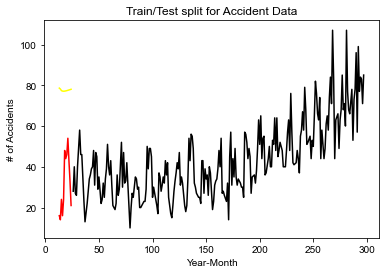

In [ ]:
import seaborn as sns 

plt.plot(working_df.WERT, color = "black")
plt.plot(ground_truth_df.WERT, color = "red")
plt.plot(forecast, color = "yellow")
plt.title("Train/Test split for Accident Data")
plt.ylabel("# of Accidents")
plt.xlabel('Year-Month')
sns.set()
plt.show()

# Machine Learning Model for prediction

### Model Selection

In [2]:
# !pip install pycaret --user
# !pip install 'Jinja2'
# !pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [119]:
import jinja2
from pycaret.regression import *
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(working_df[['JAHR', 'MONAT', 'WERT']], test_size=0.2)
s = setup(data = train_df, test_data = test_df, target = 'WERT', fold_strategy = 'timeseries', numeric_features = ['JAHR', 'MONAT'], fold = 5, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,WERT
2,Original Data,"(201, 3)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(201, 2)"


In [120]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,7.2592,85.2434,9.1783,0.7245,0.2202,0.1820,0.230
gbr,Gradient Boosting Regressor,7.5745,94.5481,9.6625,0.6795,0.2326,0.1923,0.040
knn,K Neighbors Regressor,7.7935,94.6932,9.6540,0.6970,0.2293,0.1984,0.078
ada,AdaBoost Regressor,7.8214,102.0536,10.0546,0.6669,0.2399,0.1990,0.072
et,Extra Trees Regressor,7.8433,106.1424,10.1250,0.6650,0.2374,0.1959,0.174
lightgbm,Light Gradient Boosting Machine,8.1962,116.4921,10.4825,0.5838,0.2468,0.2062,0.090
dt,Decision Tree Regressor,8.8424,130.3333,11.3044,0.5786,0.2762,0.2201,0.020
br,Bayesian Ridge,9.8997,157.6526,12.4388,0.4990,0.3045,0.2617,0.018
ridge,Ridge Regression,9.9147,156.9942,12.4188,0.5000,0.3054,0.2621,0.018
lar,Least Angle Regression,9.9155,156.9954,12.4190,0.5000,0.3055,0.2621,0.020


In [121]:
best = compare_models(sort = 'MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,7.2592,85.2434,9.1783,0.7245,0.2202,0.1820,0.232
gbr,Gradient Boosting Regressor,7.5745,94.5481,9.6625,0.6795,0.2326,0.1923,0.042
knn,K Neighbors Regressor,7.7935,94.6932,9.6540,0.6970,0.2293,0.1984,0.078
ada,AdaBoost Regressor,7.8214,102.0536,10.0546,0.6669,0.2399,0.1990,0.074
et,Extra Trees Regressor,7.8433,106.1424,10.1250,0.6650,0.2374,0.1959,0.170
lightgbm,Light Gradient Boosting Machine,8.1962,116.4921,10.4825,0.5838,0.2468,0.2062,0.030
dt,Decision Tree Regressor,8.8424,130.3333,11.3044,0.5786,0.2762,0.2201,0.018
ridge,Ridge Regression,9.9147,156.9942,12.4188,0.5000,0.3054,0.2621,0.018
lr,Linear Regression,9.9155,156.9951,12.4190,0.5000,0.3055,0.2621,0.018
lar,Least Angle Regression,9.9155,156.9954,12.4190,0.5000,0.3055,0.2621,0.020


In [122]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,7.2592,85.2434,9.1783,0.7245,0.2202,0.1820,0.232
knn,K Neighbors Regressor,7.7935,94.6932,9.6540,0.6970,0.2293,0.1984,0.078
gbr,Gradient Boosting Regressor,7.5745,94.5481,9.6625,0.6795,0.2326,0.1923,0.044
ada,AdaBoost Regressor,7.8214,102.0536,10.0546,0.6669,0.2399,0.1990,0.070
et,Extra Trees Regressor,7.8433,106.1424,10.1250,0.6650,0.2374,0.1959,0.176
lightgbm,Light Gradient Boosting Machine,8.1962,116.4921,10.4825,0.5838,0.2468,0.2062,0.026
dt,Decision Tree Regressor,8.8424,130.3333,11.3044,0.5786,0.2762,0.2201,0.018
ridge,Ridge Regression,9.9147,156.9942,12.4188,0.5000,0.3054,0.2621,0.020
lar,Least Angle Regression,9.9155,156.9954,12.4190,0.5000,0.3055,0.2621,0.022
lr,Linear Regression,9.9155,156.9951,12.4190,0.5000,0.3055,0.2621,0.020


### Model training and hyperparameter tuning with NestedCV

In [159]:
from pandas import concat, DataFrame

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  n_vars = 1 if type(data) is list else data.shape[1]
  print(n_vars)
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg


# values = [x for x in range(10)]

working_df = pd.read_csv(BASE_PATH+'working_df.csv', sep=',', header=None, index_col=0, encoding='utf-8')
working_df.columns = important_columns
working_df = working_df.reset_index(drop=True)
data = series_to_supervised(working_df.WERT.tolist())
data

1


,var1(t-1),var1(t)
1,78.0,53
2,53.0,73
3,73.0,78
4,78.0,96
5,96.0,57
...,...,...
247,58.0,46
248,46.0,46
249,46.0,34
250,34.0,23


In [161]:
start = time()
rf = RandomForestRegressor(random_state = 42)

params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    # 'max_features': ['auto', 'sqrt'],
    # 'min_samples_leaf': [1, 2, 4],
    # 'min_samples_split': [2, 5, 10],
    # 'n_estimators': [200, 400, 1000],
    'criterion': ['mae'],
    'n_jobs': [-1],
    'random_state': [42]
}

mae_scores = list()
outer_cv = TimeSeriesSplit(n_splits=5)
for train_val_index, test_index in outer_cv.split(data[['var1(t-1)', 'var1(t)']].to_numpy()):
  
  X_train_val = data[['var1(t-1)']].to_numpy()[train_val_index]
  Y_train_val = data[['var1(t)']].to_numpy()[train_val_index]
  X_test = data[['var1(t-1)']].to_numpy()[test_index]
  Y_test = data[['var1(t)']].to_numpy()[test_index]

  inner_cv = TimeSeriesSplit(n_splits=5)
  clf = GridSearchCV(estimator = rf, cv = inner_cv, refit=True, param_grid=params)
  result = clf.fit(X_train_val, Y_train_val)
  best_model = result.best_estimator_
  Y_pred = best_model.predict(X_test)
  score = mean_absolute_error(Y_test, Y_pred)
  mae_scores.append(score)
  print('>acc=%.4f, est=%.4f, cfg=%s' % (score, result.best_score_, result.best_params_))
  with open(BASE_PATH + 'models/model_'+str(score)+'.pickle', 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('MAE: %.3f (%.3f)' % (np.mean(mae_scores), np.std(mae_scores)))
end = time()
print("Fit Time:", end - start)

>acc=12.9401, est=-1.4750, cfg={'bootstrap': True, 'criterion': 'mae', 'max_depth': 10, 'n_jobs': -1, 'random_state': 42}
>acc=10.2799, est=-0.8035, cfg={'bootstrap': True, 'criterion': 'mae', 'max_depth': 10, 'n_jobs': -1, 'random_state': 42}
>acc=10.5904, est=-0.8163, cfg={'bootstrap': True, 'criterion': 'mae', 'max_depth': 10, 'n_jobs': -1, 'random_state': 42}
>acc=7.0309, est=-0.8522, cfg={'bootstrap': True, 'criterion': 'mae', 'max_depth': 10, 'n_jobs': -1, 'random_state': 42}
>acc=8.6844, est=-0.7627, cfg={'bootstrap': True, 'criterion': 'mae', 'max_depth': 10, 'n_jobs': -1, 'random_state': 42}
Accuracy: 9.905 (1.979)
Fit Time: 61.59882402420044


In [167]:
with open(BASE_PATH+'models/model_8.68439024390244.pickle', 'rb') as f:
  model = pickle.load(f)

gt = series_to_supervised(ground_truth_df.WERT.tolist())
preds = model.predict(gt[['var1(t-1)']].to_numpy())
mean_absolute_error(Y_test, Y_pred)

1


8.68439024390244

In [ ]:
outer_cv = 

# Generalization Error with Ground Truth Data